<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import warnings
warnings.simplefilter("ignore")

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from pymystem3 import Mystem
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from tqdm.notebook import tqdm

In [2]:
RANDOM_STATE = 107

In [3]:
try:
    toxic_comments = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    toxic_comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

In [4]:
def descr (df):
    display(df.sample(5))
    print('---------------------------------------------------------------------------------------------------------')
    display(df.info()) 
    print('---------------------------------------------------------------------------------------------------------')
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print('---------------------------------------------------------------------------------------------------------')
    print(f'Количество пропусков:  {df.isna().sum()}')
    print('---------------------------------------------------------------------------------------------------------')
    print(f'Описание: ')
    display(df.describe())
    print('---------------------------------------------------------------------------------------------------------')
    print(f'Размер: {df.shape}')

In [5]:
descr(toxic_comments)

,text,toxic
107839,I don't think so because libertarianism would ...,0
121608,"HAWKINGS RADIATION\nhEM, why it is uncomprehen...",0
140513,Infobox War faction or country? \n\nShould the...,0
72795,Will Always Loathe You]]\n Bye Bye Ball,1
42474,Contradiction\nThe article states Wiggum using...,0


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:  text     0
toxic    0
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


---------------------------------------------------------------------------------------------------------
Размер: (159292, 2)


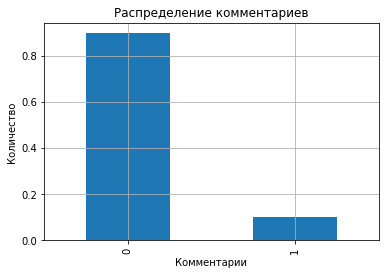

In [6]:
toxic_comments['toxic'].value_counts(normalize = (0,1)).plot(kind='bar', grid = True)
plt.title('Распределение комментариев')
plt.xlabel('Комментарии')
plt.ylabel('Количество')
plt.show()
plt.show()

**Выводы**

Мы загрузили данные. Размер датасета составлял 159292 строки и 3 столбца, после удаления дублирующго столбца осталось  159292 строки и 2 столбца

Целевой признак toxic - не сбалансирован классами с перевесом в пользу класса 0. 

## Обучение

In [7]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tagged_tokens]
    lemmatized_text = ' '.join(lemmas)
    cleaned_text = re.sub(r'[^a-zA-Z\' ]', '', lemmatized_text)
    cleaned_text = cleaned_text.replace('\n', '')
    
    return cleaned_text

In [9]:
tqdm.pandas()
toxic_comments['lemm_text'] = toxic_comments['text'].progress_apply(clean_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [10]:
toxic_comments = toxic_comments.drop(['text'], axis=1)
descr(toxic_comments)

,toxic,lemm_text
94742,0,fortunately the real outcome of the war be tha...
29519,1,also the ip attacker be from california where...
69272,1,kitten i throw them against the wall ''
128193,0,you be more than welcome to add something i ...
155445,0,this be n't war what about his comment about ...


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   toxic      159292 non-null  int64 
 1   lemm_text  159292 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 627
---------------------------------------------------------------------------------------------------------
Количество пропусков:  toxic        0
lemm_text    0
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


---------------------------------------------------------------------------------------------------------
Размер: (159292, 2)


Мы видим что у нас после лемматизизации и очистке текста появилось  1276 дубликатов, удалим их

In [11]:
toxic_comments = toxic_comments.drop_duplicates()
toxic_comments.duplicated().sum()

0

*Разбивка на выборки*

In [12]:
X = toxic_comments.drop('toxic', axis = 1)
y = toxic_comments['toxic']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.4,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)

In [13]:
print(f'Размер тренировочной выборки: {X_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')   

Размер тренировочной выборки: (95199, 1)
Размер тестовой выборки: (63466, 1)


*Создадим пайплайн*

In [14]:
pipeline = Pipeline(
    [
        ('vect', TfidfVectorizer(stop_words=stopwords)),
        ('clf', LogisticRegression(solver='liblinear', random_state = RANDOM_STATE)),
    ]
)
param_grid = [
    {
        'clf': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'clf__max_depth': range(2, 8)
    },
    {
        'clf': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
        )],
        'clf__penalty': ('l1', 'l2'),
        'clf__C': list(range(5, 15, 1))
    }
]

In [15]:
r_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    scoring='f1',
    n_iter=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    cv=5,
    error_score='raise'
)
r_search.fit(X_train['lemm_text'], y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words={'a',
                                                                          'about',
                                                                          'above',
                                                                          'after',
                                                                          'again',
                                                                          'against',
                                                                          'ain',
                                                                          'all',
                                                                          'am',
                                                                          'an',
                                                                          'and',
 

In [16]:
print('Лучшие параметры:', r_search.best_params_)
print('Лучшая метрика F1:', r_search.best_score_)

Лучшие параметры: {'clf__penalty': 'l2', 'clf__C': 11, 'clf': LogisticRegression(C=11, random_state=107, solver='liblinear')}
Лучшая метрика F1: 0.7668028365460003


Предсказание модели

In [17]:
preds = r_search.predict(X_test['lemm_text'])
print('Лучшая метрика F1 на тестовой выборке:', f1_score(y_test, preds))

Лучшая метрика F1 на тестовой выборке: 0.7682788671023965


## Выводы

Мы загрузили данные. Размер датасета составлял 159292 строки и 3 столбца, после удаления дублирующего столбца осталось 159292 строки и 2 столбца. Пропущенных значений и дубликатов не обнаружено.


Мы видим что у нас после лемматизизации и очистке текста появилось 1276 дубликатов, мы их удалили. Что в принципе, не совсем верно учитывая то, что могут быть похожие комментарии, которые после очистки могут стать дубликатами.

Провели обучение модели и получили:

- Лучшие параметры: {'clf__penalty': 'l2', 'clf__C': 11, 'clf': LogisticRegression(C=11, random_state=107, solver='liblinear')}
- Лучшая метрика F1: 0.7641251370092481
- Лучшая метрика F1 на тестовой выборке: 0.7667399912010558

Что соответствует условию задачи

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны